In [25]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# create server status table
# link user engagement & retention & payment with server status
# ml
# tbh personally would be more interested in ranking, d_ranking, etc

In [3]:
S_ROOT = r'data/'

In [4]:
df_createrole_login = pd.read_csv(S_ROOT + 'createrole_login_record.csv')
df_session = pd.read_csv(S_ROOT + 'user_daily_session_length_record.csv')
df_p = pd.read_csv(S_ROOT + 'user_payment_record.csv').rename({'date':'dt'}, axis=1)

In [5]:
df_createrole_login

,appid,dt,ctwid,server_id,type,time
0,test,2024-11-17,84a787b8d4,44,g_login,1731843941000
1,test,2024-11-17,42fa4799c1,34,g_login,1731843977000
2,test,2024-11-17,96c22d3440,60,g_login,1731843979000
3,test,2024-11-17,def76d1d2b,9,g_login,1731843937000
4,test,2024-11-17,5ece9bf10e,18,g_login,1731843984000
...,...,...,...,...,...,...
3832730,test,2024-10-18,f42abc1ce5,1,g_login,1729263590000
3832731,test,2024-10-18,be64dcba91,1,g_login,1729263529000
3832732,test,2024-10-18,e7b71af6bf,1,g_login,1729263598000
3832733,test,2024-11-03,745a5a9d69,3,g_login,1730645998000


In [6]:
df_session

,appid,dt,ctwid,session_length
0,test,2024-11-17,a512b8cf9b,17
1,test,2024-11-17,5601d6307c,1898
2,test,2024-11-17,a0e52a52cc,1894
3,test,2024-11-17,88321a495c,1
4,test,2024-11-17,0d649666d6,6185
...,...,...,...,...
2755439,test,2024-10-29,8f3fd1c742,12947
2755440,test,2024-10-29,3a6d1ab888,316
2755441,test,2024-10-29,a7659fd0d9,5295
2755442,test,2024-10-29,538844702d,601


In [7]:
df_p

,appid,dt,ctwid,server_id,time,pay_amt
0,test,2024-11-13,23dccf736f,2,1731509951124,100
1,test,2024-11-13,2cac52ff60,3,1731509996850,100
2,test,2024-11-13,af687842ae,43,1731509995400,100
3,test,2024-11-14,44f3cee987,43,1731510028964,1
4,test,2024-11-14,01c6034980,9,1731510053112,79
...,...,...,...,...,...,...
106505,test,2024-11-06,67e0a2383a,4,1730904349467,100
106506,test,2024-11-06,2d019a85af,4,1730904653874,100
106507,test,2024-11-06,a9fff2307d,8,1730904862305,100
106508,test,2024-11-06,e64eb351e8,14,1730905048959,1


In [9]:
for df in (df_createrole_login, df_session, df_p):
    df['dt'] = pd.to_datetime(df['dt'])

In [47]:
# Data cleaning

# # Checked: all records in session have matching records in createrole_login
# df_createrole_login_unique = df_createrole_login.groupby(['ctwid', 'dt'])['type'].count().reset_index()
# df_createrole_login_unique['type'] = 1
# df_session_match = df_session.merge(df_createrole_login_unique, how='left', on=['ctwid', 'dt'])
# print(df_session_match['type'].value_counts())

# If there is no createrole record for an account, switch the first one into createrole
n_switch_createrole = 0
for ctwid, df_ctwid in df_createrole_login.groupby('ctwid'):
    df_ctwid = df_ctwid.sort_values('time')
    if 'g_createrole' != df_ctwid.loc[df_ctwid.index[0], 'type']:
        n_switch_createrole += 1
        df_ctwid.loc[df_ctwid.index[0], 'type'] = 'g_createrole'
print('Forced %d initial records into g_createrole' % n_switch_createrole)


Forced 53801 initial records into g_createrole


In [70]:
# Server status stats
df_createrole = df_createrole_login[df_createrole_login['type']=='g_createrole']
df_server_creation = df_createrole.groupby('server_id')['dt'].min().reset_index().rename({'dt':'server_creation_dt'}, axis=1)

df_server_status = df_createrole.groupby(['server_id', 'dt'])['type']\
    .count().reset_index().rename({'type':'server_new_account'}, axis=1)
df_server_status['server_total_account'] = df_server_status.groupby('server_id')['server_new_account']\
    .rolling(999, min_periods=1).sum().values
df_server_status = df_server_status.merge(df_server_creation, on='server_id')
df_server_status['server_day'] = [x.days for x in df_server_status['dt'] - df_server_status['server_creation_dt']]

df_server_login = df_createrole_login.groupby(['server_id', 'dt', 'ctwid'])['type'].count().reset_index()\
    .groupby(['server_id', 'dt'])['type'].count().reset_index().rename({'type':'daily_active_account'}, axis=1)
df_server_status = df_server_status.merge(df_server_login, on=['server_id', 'dt'])

df_player_payment = df_p.groupby(['ctwid', 'server_id', 'dt'])['pay_amt'].sum().reset_index()
df_player_payment['pay_count'] = df_p.groupby(['ctwid', 'server_id', 'dt'])['pay_amt'].count().values
df_player_payment['acc_pay_amt'] = df_player_payment.groupby(['ctwid', 'server_id'])['pay_amt'].rolling(999, min_periods=1).sum().values
df_player_payment['acc_pay_count'] = df_player_payment.groupby(['ctwid', 'server_id'])['pay_count'].rolling(999, min_periods=1).sum().values

df_server_status = df_server_status.merge(df_player_payment.groupby(['server_id', 'dt'])[['pay_amt', 'pay_count']].sum(), 
                                          how='left', on=['server_id', 'dt'])
df_server_spenders = df_player_payment.groupby(['server_id', 'dt'])['ctwid'].count()\
    .reset_index().rename({'ctwid': 'spenders'}, axis=1)  # this is a trivial number
df_server_status = df_server_status.merge(df_server_spenders, how='left', on=['server_id', 'dt'])
df_server_whales = df_player_payment[df_player_payment['acc_pay_amt'] > 10000].groupby(['server_id', 'dt'])['ctwid'].count()\
    .reset_index().rename({'ctwid': 'whales'}, axis=1)  # this is a trivial number
df_server_status = df_server_status.merge(df_server_whales, how='left', on=['server_id', 'dt'])
df_server_status['arpdau'] = df_server_status['pay_amt'] / df_server_status['daily_active_account']
df_server_status['daily_conversion'] = df_server_status['spenders'] / df_server_status['daily_active_account']
df_server_status['arppu'] = df_server_status['pay_amt'] / df_server_status['spenders']

df_server_status

,server_id,dt,server_new_account,server_total_account,server_creation_dt,server_day,daily_active_account,pay_amt,pay_count,spenders,whales,arpdau,daily_conversion,arppu
0,1,2024-10-18,2039,2039.0,2024-10-18,0,2199,486739,1097,381,8.0,221.345612,0.173261,1277.530184
1,1,2024-10-19,1025,3064.0,2024-10-18,1,2054,579114,1000,268,27.0,281.944499,0.130477,2160.873134
2,1,2024-10-20,1408,4472.0,2024-10-18,2,2548,587047,837,264,32.0,230.395212,0.103611,2223.662879
3,1,2024-10-21,995,5467.0,2024-10-18,3,2353,494088,583,225,39.0,209.982150,0.095623,2195.946667
4,1,2024-10-22,575,6042.0,2024-10-18,4,1967,478792,402,174,43.0,243.412303,0.088460,2751.678161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,74,2024-11-18,5216,5216.0,2024-11-18,0,5762,110081,367,133,3.0,19.104651,0.023082,827.676692
149,75,2024-11-18,5178,5178.0,2024-11-18,0,5753,98058,288,101,1.0,17.044672,0.017556,970.871287
150,76,2024-11-18,5245,5245.0,2024-11-18,0,5726,87711,274,97,3.0,15.318023,0.016940,904.237113
151,77,2024-11-18,5382,5382.0,2024-11-18,0,5822,46925,169,84,1.0,8.059945,0.014428,558.630952


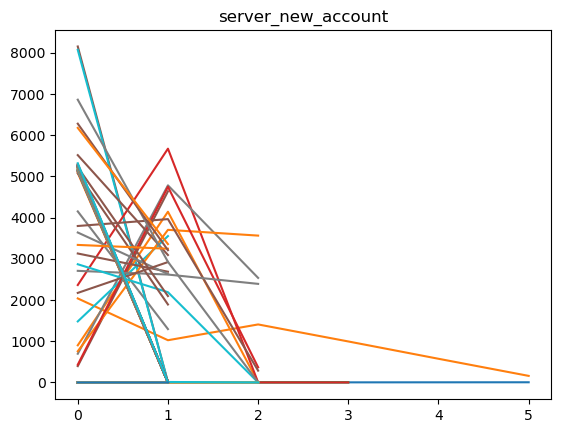

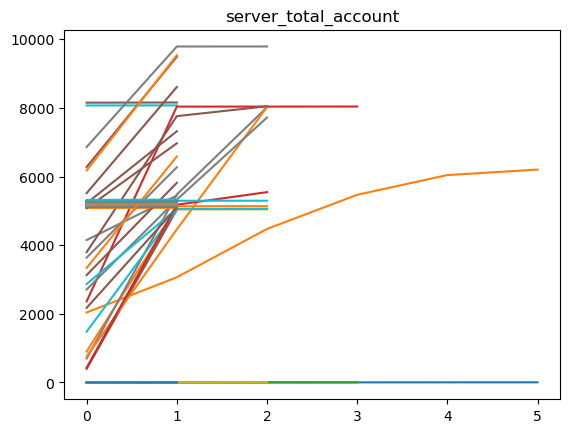

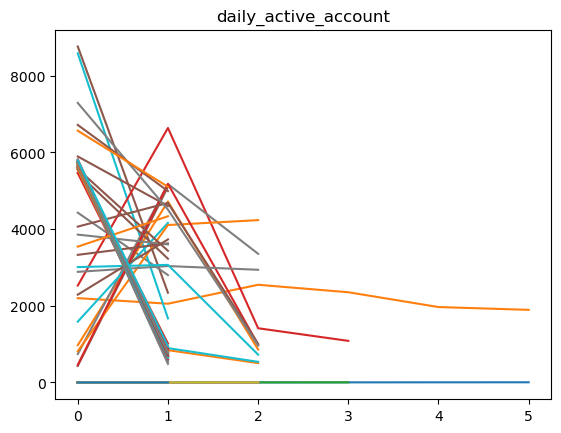

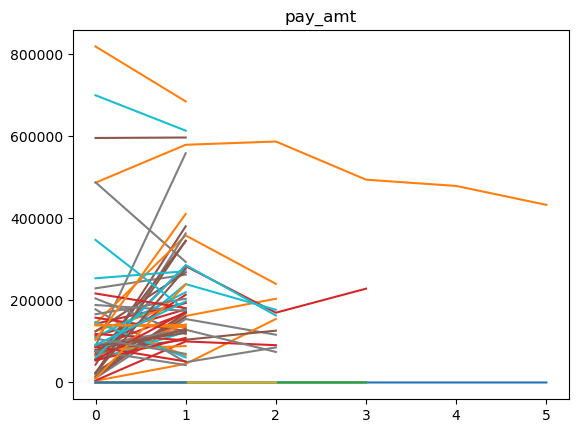

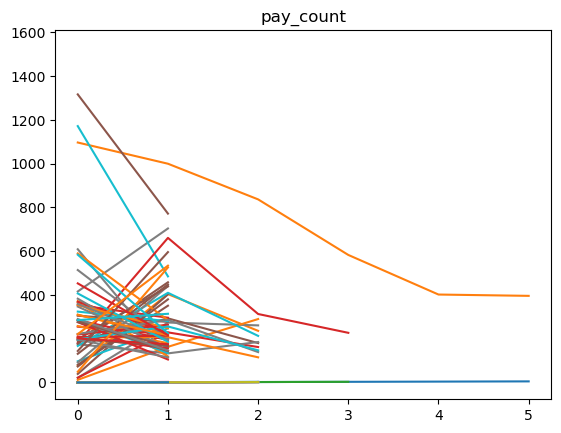

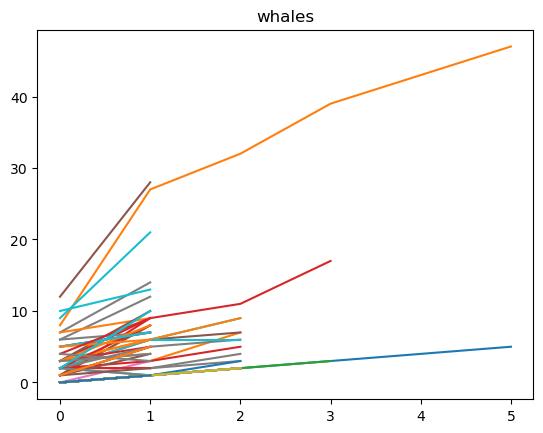

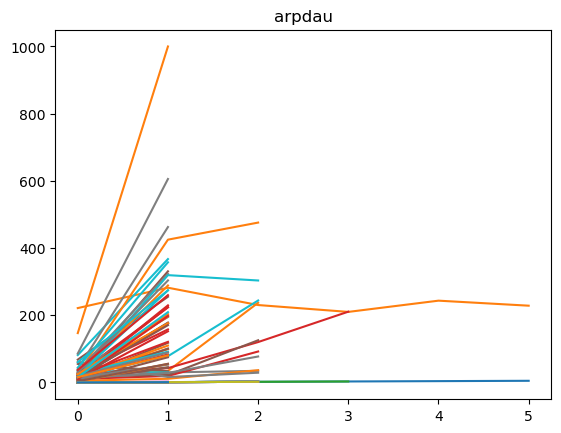

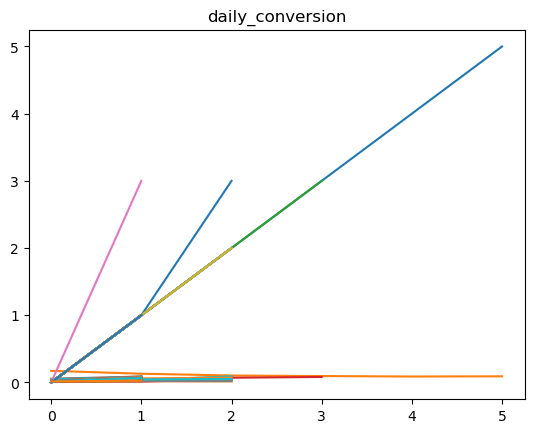

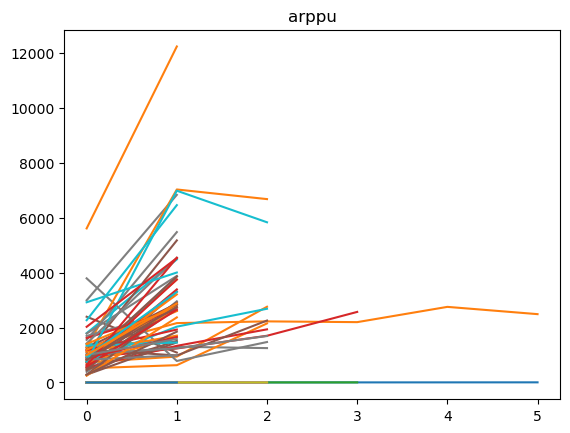

In [71]:
for c in ('server_new_account', 'server_total_account', 'daily_active_account', 'pay_amt', 'pay_count', 'whales', 
          'arpdau', 'daily_conversion', 'arppu'):
    plt.figure()
    for server_id in range(1, 79):
        plt.plot(df_server_status.loc[df_server_status['server_id']==server_id, ['server_day', c]].values)
    plt.title(c)
    plt.show()

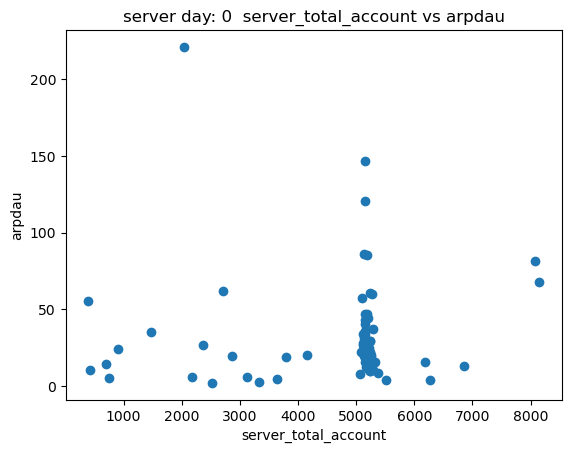

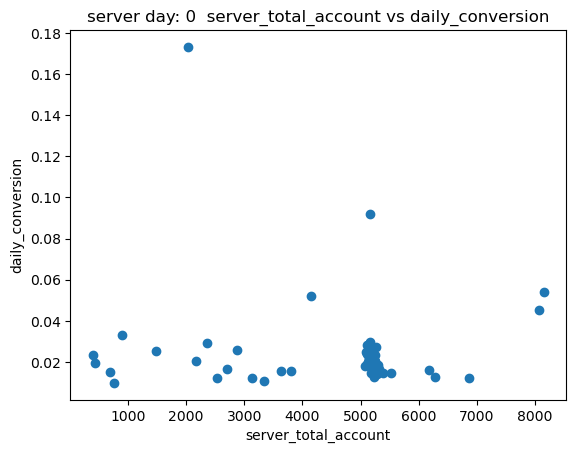

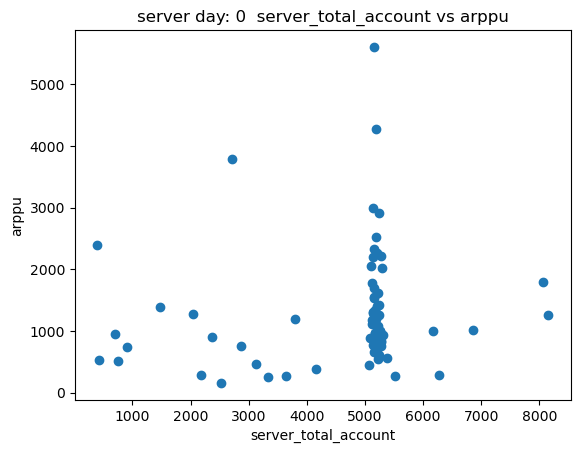

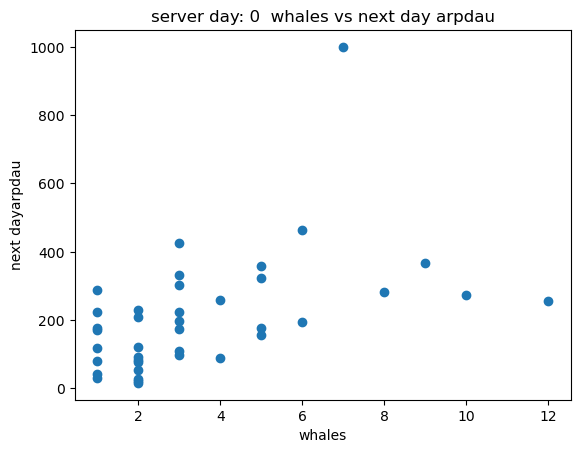

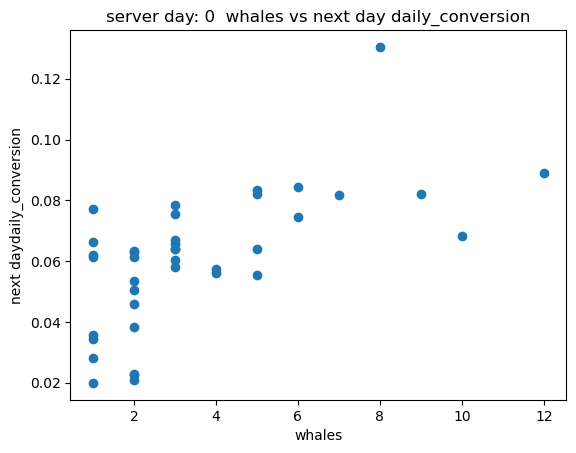

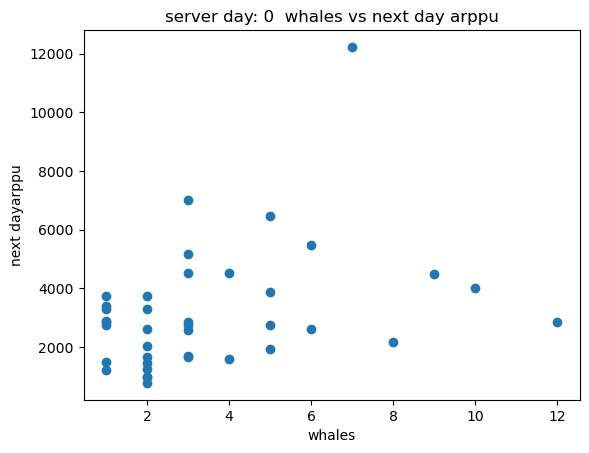

In [83]:
sd = 0
x = 'server_total_account'
for y in ('arpdau', 'daily_conversion', 'arppu'):
    plt.figure()
    plt.scatter(df_server_status.loc[df_server_status['server_day']==sd, x].values, 
                df_server_status.loc[df_server_status['server_day']==sd, y].values)
    plt.title('server day: ' + str(0) + '  ' + x + ' vs ' + y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

sd = 0
x = 'whales'
for y in ('arpdau', 'daily_conversion', 'arppu'):
    plt.figure()
    df0 = df_server_status.loc[df_server_status['server_day']==sd, ['server_id', x]]
    df1 = df_server_status.loc[df_server_status['server_day']==sd+1, ['server_id', y]]
    df = df0.merge(df1, on='server_id')
    plt.scatter(df[x].values, 
                df[y].values)
    plt.title('server day: ' + str(0) + '  ' + x + ' vs next day ' + y)
    plt.xlabel(x)
    plt.ylabel('next day' + y)
    plt.show()